In [1]:
# import all necessary libraries

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
#
!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

!conda install -c conda-forge bs4 --yes
from bs4 import BeautifulSoup

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.21.0               |             py_0          58 KB  conda-forge
    certifi-2020.4.5.1         |   py36h9f0ad1d_0         151 KB  conda-forge
    ca-certificates-2020.4.5.1 |       hecc5488_0         146 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0         conda-forge
    geopy:           1

In [2]:
# Parsing CSV of all UK Districts
allRegionsdf = pd.read_csv('https://www.doogal.co.uk/PostcodeDistrictsCSV.ashx')
allRegionsdf.shape
# allRegionsdf.head()

(3114, 13)

In [3]:
# Removing unwanted data columns and data modification
# Remove every region not part of London

allRegionsdf.drop(axis = 1, columns = ['Easting', 'Northing', 'Grid Reference', 'Postcodes', 'Active postcodes', 'Population', 'Households', 'Nearby districts'], inplace = True)

otherRegions = ['N', 'E', 'SE', 'SW', 'W']
londonRegions = pd.DataFrame([])
for region in otherRegions:
    indexnames = allRegionsdf[(allRegionsdf['Postcode'].str.startswith(region))]
    londonRegions = londonRegions.append(indexnames)
    

otherRegions = ['WS', 'NE', 'WR', 'WV', 'EX', 'EN', 'EH', 'NG', 'WF', 'WN', 'WD', 'NN', 'WA', 'NP', 'NR']
for region in otherRegions:
    indexnames = londonRegions[(londonRegions['Postcode'].str.startswith(region))].index
    londonRegions.drop(indexnames, inplace = True)
    
indexnames = londonRegions[(londonRegions['Town/Area'].str.contains('Non-geographic'))].index
londonRegions.drop(indexnames, inplace = True)

otherRegions = ['WC99', 'N1C', 'E1W']
for region in otherRegions:
    indexnames = londonRegions[(londonRegions['Postcode'] == region)].index
    londonRegions.drop(indexnames, inplace = True)
    
otherRegions = ['WC1', 'WC2', 'EC1', 'EC2', 'EC3', 'EC4']

for region in otherRegions:
    indexnames = londonRegions[(londonRegions['Postcode'].str.startswith(region))].index
    londonRegions.drop(indexnames, inplace = True)
otherRegions = ['SW1A', 'SW1B', 'SW1E', 'SW1H', 'SW1P', 'SW1V', 'SW1W', 'SW1X', 'SW1Y',
           'W1A', 'W1B', 'W1C', 'W1D', 'W1F', 'W1M', 'W1N', 'W1P', 'W1R',  'W1V', 'W1X', 'W1M', 'W1Y', 'W1G', 'W1H', 'W1J', 'W1K', 'W1S', 'W1T', 'W1U', 'W1W']
for region in otherRegions:
    indexnames = londonRegions[(londonRegions['Postcode'] == region)].index
    londonRegions.drop(indexnames, inplace = True)

In [4]:
# Add Data manually for Central London
tempdf = [pd.Series(['EC1', '51.523', '-0.092000', 'City of London, Islington, Camden, Hackney', 'Eastern Central'], index = londonRegions.columns) ,
        pd.Series(['EC2', '51.518', '-0.084000', 'Islington, Hackney, City of London, Tower Hamlets', 'Eastern Central'], index = londonRegions.columns) ,
        pd.Series(['EC3', '51.508', '-0.076000', 'Tower Hamlets, City of London', 'Eastern Central'], index = londonRegions.columns) ,
        pd.Series(['EC4', '51.511', '-0.098000', 'City of London, Westminster', 'Eastern Central'], index = londonRegions.columns) ,
        pd.Series(['WC1', '51.514', '-0.120000', 'Camden, City of London, Islington', 'Western Central'], index = londonRegions.columns) ,
        pd.Series(['WC2', '51.514', '-0.124000', 'Camden, Westminster, City of London', 'Western Central'], index = londonRegions.columns) ,
        pd.Series(['SW1', '51.503', '-0.131000', 'Westminster, Kensington and Chelsea', 'South West Central'], index = londonRegions.columns) ,
        pd.Series(['W1', '51.516', '-0.140000', 'Westminster, Camden', 'West Central'], index = londonRegions.columns) ,]

In [5]:
# Final Data modification for analysis 
londonRegionsdf = londonRegions.append(tempdf , ignore_index=True)
londonRegionsdf.rename(index=str, columns={"Town/Area": "Neighborhood"}, inplace = True)
londonRegionsdf[(londonRegionsdf['Postcode'].str.startswith('E'))]
londonRegionsdf.shape
londonRegionsdf.tail(10)

,Postcode,Latitude,Longitude,Neighborhood,Region
110,W13,51.5131,-0.321413,"West Ealing, Northfields",Ealing
111,W14,51.4954,-0.211156,"West Kensington, Kensington Olympia, Holland Park",Kensington and Chelsea
112,EC1,51.523,-0.092000,"City of London, Islington, Camden, Hackney",Eastern Central
113,EC2,51.518,-0.084000,"Islington, Hackney, City of London, Tower Hamlets",Eastern Central
114,EC3,51.508,-0.076000,"Tower Hamlets, City of London",Eastern Central
115,EC4,51.511,-0.098000,"City of London, Westminster",Eastern Central
116,WC1,51.514,-0.120000,"Camden, City of London, Islington",Western Central
117,WC2,51.514,-0.124000,"Camden, Westminster, City of London",Western Central
118,SW1,51.503,-0.131000,"Westminster, Kensington and Chelsea",South West Central
119,W1,51.516,-0.140000,"Westminster, Camden",West Central


In [36]:
# Define Foursquare Credentials and Version
LIMIT =200
radius = 1000
#SENSITIVE DATA
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret

VERSION = '20180605' # Foursquare API version
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 
CLIENT_SECRET:


In [7]:
# Location Coordinates for London
address = 'London, ldn'

geolocator = Nominatim(user_agent="ldn_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of London are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of London are 51.51336310000001, -0.14834169995473073.


In [8]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
#         make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
#         print(requests.get(url).json()["response"])
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [9]:
# Getting the top 200 nearby venues for all Neighborhoods in Toronto and producing a pandas Dataframe
neighborhoodVenues = getNearbyVenues(names=londonRegionsdf['Neighborhood'],
                                   latitudes=londonRegionsdf['Latitude'],
                                   longitudes=londonRegionsdf['Longitude']
                                  )


Barnsbury, Canonbury, Kings Cross, Islington, Pentonville, De Beauvoir Town, Hoxton
East Finchley, Fortis Green, Hampstead Garden Suburb
Finchley, Church End, Finchley Central
Finsbury Park, Manor House, Harringay, Stroud Green
Highbury, Highbury Fields
Highgate, Hampstead Heath
Holloway, Barnsbury, Islington, Tufnell Park
Hornsey, Crouch End, Harringay
Lower Edmonton, Edmonton
Muswell Hill
New Southgate, Friern Barnet, Bounds Green, Arnos Grove
North Finchley, Woodside Park
Palmers Green
Southgate, Oakwood, Arnos Grove
West Green, Seven Sisters, Duckett's Green
Stoke Newington, Stamford Hill, Shacklewell, Dalston, Newington Green
Tottenham, South Tottenham
Upper Edmonton, Edmonton
Upper Holloway, Archway, Tufnell Park, Hornsey
Whetstone, Totteridge, Oakleigh Park
Winchmore Hill, Bush Hill, Grange Park
Wood Green, Bounds Green, Bowes Park
Euston, Camden Town, Somers Town, Primrose Hill, Gospel Oak, Lisson Grove
Cricklewood, Willesden, Neasden, Dollis Hill, Childs Hill
Hampstead, Chalk 

In [10]:
print('There are {} uniques categories.'.format(len(neighborhoodVenues['Venue Category'].unique())))
neighborhoodVenues.head()

There are 382 uniques categories.


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Barnsbury, Canonbury, Kings Cross, Islington, ...",51.5376,-0.0982429,Steve Hatt,51.538588,-0.099041,Fish Market
1,"Barnsbury, Canonbury, Kings Cross, Islington, ...",51.5376,-0.0982429,Saponara,51.536875,-0.096121,Italian Restaurant
2,"Barnsbury, Canonbury, Kings Cross, Islington, ...",51.5376,-0.0982429,The Life Centre Islington,51.538056,-0.099171,Yoga Studio
3,"Barnsbury, Canonbury, Kings Cross, Islington, ...",51.5376,-0.0982429,Pophams,51.536666,-0.096175,Bakery
4,"Barnsbury, Canonbury, Kings Cross, Islington, ...",51.5376,-0.0982429,Raabs The Bakers,51.539463,-0.097768,Bakery


In [11]:
# One hot encoding
neighborhoodOnehot = pd.get_dummies(neighborhoodVenues[['Venue Category']], prefix="", prefix_sep="")

# Adding neighborhood column back to dataframe
neighborhoodOnehot['Neighborhood'] = neighborhoodVenues['Neighborhood'] 

# Moving neighborhood column to the first column
fixed_columns = [neighborhoodOnehot.columns[-1]] + list(neighborhoodOnehot.columns[:-1])
neighborhoodOnehot = neighborhoodOnehot[fixed_columns]

In [12]:
neighborhoodGrouped = neighborhoodOnehot.groupby('Neighborhood').mean().reset_index()
neighborhoodGrouped.shape
neighborhoodGrouped.head()

,Neighborhood,Zoo Exhibit,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bar,Baseball Field,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bistro,Boarding House,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Building,Bulgarian Restaurant,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Camera Store,Campground,Canal,Canal Lock,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Caucasian Restaurant,Champagne Bar,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Cigkofte Place,Circus School,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Roaster,Coffee Shop,College Cafeteria,College Quad,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cricket Ground,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Fishing Store,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Field,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,Hunan Restaurant,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Laser Tag,Latin American Restaurant,Lebanese Restaurant,Library,Light Rail Station,Lighthouse,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Observatory,Office,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Outdoor Gym,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Pakistani Restaurant,Palace,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pier,Pilates Studio,Pizza Place,Planetarium,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Post Office,P

In [13]:
# Defining a function to sort venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [14]:
# Creating a Dataframe to display the top 20 venues of each Neighborhood

num_top_venues = 20

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = neighborhoodGrouped['Neighborhood']

for ind in np.arange(neighborhoodGrouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(neighborhoodGrouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
0,"Abbey Wood, West Heath, Crossness, Thamesmead",Supermarket,Platform,Grocery Store,Train Station,Convenience Store,Coffee Shop,Campground,Historic Site,Zoo,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fishing Store,Fish Market,Fabric Shop,Flea Market,Flower Shop
1,"Acton, East Acton, Park Royal, West Acton",Pub,Gym / Fitness Center,Train Station,Grocery Store,Hotel,Platform,Coffee Shop,Park,Fast Food Restaurant,Breakfast Spot,Playground,Gas Station,Metro Station,Deli / Bodega,Middle Eastern Restaurant,Mini Golf,Brewery,Food & Drink Shop,Museum,Café
2,"Aldgate, Bishopsgate, Whitechapel, Shoreditch,...",Coffee Shop,Pub,Hotel,Indian Restaurant,Café,Vegetarian / Vegan Restaurant,Bar,Pizza Place,Ice Cream Shop,Bakery,Middle Eastern Restaurant,Turkish Restaurant,Art Gallery,Korean Restaurant,Movie Theater,Event Space,Recreation Center,Record Shop,Falafel Restaurant,Brewery
3,"Anerley, Crystal Palace, Penge, Beckenham",Pub,Fast Food Restaurant,Grocery Store,Supermarket,Train Station,Pizza Place,Park,Convenience Store,Coffee Shop,Hotel,Gas Station,Tapas Restaurant,Sculpture Garden,Farm,Outdoor Sculpture,Music Store,Track Stadium,Hardware Store,Tram Station,Garden Center
4,"Balham, Clapham South, Hyde Farm",Coffee Shop,Pub,Pizza Place,Grocery Store,Bakery,Indian Restaurant,Supermarket,Italian Restaurant,Bar,Fast Food Restaurant,Sandwich Place,Café,Steakhouse,Breakfast Spot,Hotel,Farmers Market,Gastropub,Organic Grocery,Bookstore,Brewery


In [15]:
neighborhoodGrouped.head()

,Neighborhood,Zoo Exhibit,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bar,Baseball Field,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bistro,Boarding House,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Building,Bulgarian Restaurant,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Camera Store,Campground,Canal,Canal Lock,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Caucasian Restaurant,Champagne Bar,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Cigkofte Place,Circus School,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Roaster,Coffee Shop,College Cafeteria,College Quad,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cricket Ground,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Fishing Store,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Field,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,Hunan Restaurant,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Laser Tag,Latin American Restaurant,Lebanese Restaurant,Library,Light Rail Station,Lighthouse,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Observatory,Office,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Outdoor Gym,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Pakistani Restaurant,Palace,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pier,Pilates Studio,Pizza Place,Planetarium,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Post Office,P

## Cluster Neighborhoods

In [17]:
# running k-means clustering for diferent numbers of clusters to find the optimum value of 'k'
Sum_of_squared_distances = []
neighborhoodGroupedClustering = neighborhoodGrouped.drop('Neighborhood', 1)
K = range(1,7)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(neighborhoodGroupedClustering)
    Sum_of_squared_distances.append(km.inertia_)
    
Sum_of_squared_distances

[3.133297386209824,
 2.8642213509689998,
 2.6829903133118487,
 2.583282850101841,
 2.5031566564507726,
 2.4029174738646897]

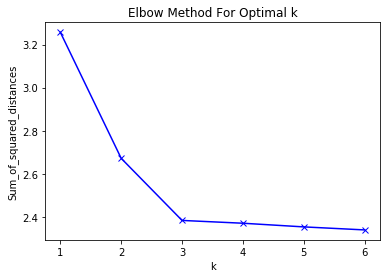

In [18]:
# visualising the otimum number of 'k' i.e. the elbow method
plt.plot(K, Sum_of_squared_distance, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [19]:
# Clustering the Neighborhoods into 4 clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(neighborhoodGroupedClustering)
kmeans.labels_

array([2, 2, 1, 2, 0, 1, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 1, 1, 2, 1, 0,
       0, 1, 1, 0, 2, 0, 0, 0, 1, 0, 0, 2, 0, 1, 2, 0, 2, 0, 0, 2, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 2, 0, 2, 0, 2, 0, 2, 2,
       2, 0, 0, 0, 2, 2, 0, 1, 0, 0, 0, 2, 0, 2, 1, 0, 0, 2, 1, 1, 2, 2,
       2, 0, 1, 0, 0, 0, 2, 2, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2,
       0, 0, 1, 1, 0, 2, 1, 2, 0, 2], dtype=int32)

In [20]:
# Adding clustering labels
# neighborhoods_venues_sorted.drop('Cluster Labels', axis=1, inplace=True)
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)


neighborhoodMerged = londonRegionsdf

# Merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
neighborhoodMerged = neighborhoodMerged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
neighborhoodMerged.head()

,Postcode,Latitude,Longitude,Neighborhood,Region,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
0,N1,51.5376,-0.0982429,"Barnsbury, Canonbury, Kings Cross, Islington, ...",Hackney,0,Pub,Coffee Shop,Bakery,Park,Japanese Restaurant,Boutique,Burger Joint,Mediterranean Restaurant,Gastropub,Ice Cream Shop,Trail,Spa,Music Venue,Gym / Fitness Center,French Restaurant,Indian Restaurant,Fish Market,Arts & Crafts Store,Cocktail Bar,Theater
1,N2,51.5903,-0.168651,"East Finchley, Fortis Green, Hampstead Garden ...",Barnet,0,Pub,Bus Stop,Park,Coffee Shop,Grocery Store,Indian Restaurant,Pizza Place,Café,Italian Restaurant,Japanese Restaurant,Train Station,French Restaurant,Movie Theater,Chinese Restaurant,Outdoors & Recreation,Shoe Store,Middle Eastern Restaurant,Metro Station,Seafood Restaurant,Greek Restaurant
2,N3,51.6004,-0.194102,"Finchley, Church End, Finchley Central",Barnet,2,Turkish Restaurant,Coffee Shop,Indian Restaurant,Supermarket,Park,Pub,Restaurant,Fast Food Restaurant,Pizza Place,Gym / Fitness Center,Japanese Restaurant,Toy / Game Store,Persian Restaurant,Ice Cream Shop,Sandwich Place,Pharmacy,Seafood Restaurant,Chinese Restaurant,Middle Eastern Restaurant,Smoke Shop
3,N4,51.571,-0.10413,"Finsbury Park, Manor House, Harringay, Stroud ...",Haringey,0,Pub,Turkish Restaurant,Café,Coffee Shop,Pizza Place,Italian Restaurant,Hotel,Gym / Fitness Center,Sandwich Place,Bakery,Trail,Clothing Store,Tapas Restaurant,Supermarket,Reservoir,Park,Vietnamese Restaurant,Indian Restaurant,Restaurant,Fish & Chips Shop
4,N5,51.5538,-0.0985844,"Highbury, Highbury Fields",Islington,0,Café,Pub,Turkish Restaurant,Coffee Shop,Italian Restaurant,Soccer Stadium,Park,Vietnamese Restaurant,Pizza Place,Thai Restaurant,Bar,Restaurant,Ethiopian Restaurant,Gym / Fitness Center,Sports Bar,French Restaurant,Middle Eastern Restaurant,Seafood Restaurant,Fish & Chips Shop,Wine Shop


In [21]:
neighborhoodMerged = neighborhoodMerged.dropna()
neighborhoodMerged['Cluster Labels'] = neighborhoodMerged['Cluster Labels'].astype(int)
neighborhoodMerged['Latitude'] = neighborhoodMerged['Latitude'].astype(float)
neighborhoodMerged['Longitude'] = neighborhoodMerged['Longitude'].astype(float)
neighborhoodMerged.head()

,Postcode,Latitude,Longitude,Neighborhood,Region,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
0,N1,51.5376,-0.098243,"Barnsbury, Canonbury, Kings Cross, Islington, ...",Hackney,0,Pub,Coffee Shop,Bakery,Park,Japanese Restaurant,Boutique,Burger Joint,Mediterranean Restaurant,Gastropub,Ice Cream Shop,Trail,Spa,Music Venue,Gym / Fitness Center,French Restaurant,Indian Restaurant,Fish Market,Arts & Crafts Store,Cocktail Bar,Theater
1,N2,51.5903,-0.168651,"East Finchley, Fortis Green, Hampstead Garden ...",Barnet,0,Pub,Bus Stop,Park,Coffee Shop,Grocery Store,Indian Restaurant,Pizza Place,Café,Italian Restaurant,Japanese Restaurant,Train Station,French Restaurant,Movie Theater,Chinese Restaurant,Outdoors & Recreation,Shoe Store,Middle Eastern Restaurant,Metro Station,Seafood Restaurant,Greek Restaurant
2,N3,51.6004,-0.194102,"Finchley, Church End, Finchley Central",Barnet,2,Turkish Restaurant,Coffee Shop,Indian Restaurant,Supermarket,Park,Pub,Restaurant,Fast Food Restaurant,Pizza Place,Gym / Fitness Center,Japanese Restaurant,Toy / Game Store,Persian Restaurant,Ice Cream Shop,Sandwich Place,Pharmacy,Seafood Restaurant,Chinese Restaurant,Middle Eastern Restaurant,Smoke Shop
3,N4,51.5710,-0.104130,"Finsbury Park, Manor House, Harringay, Stroud ...",Haringey,0,Pub,Turkish Restaurant,Café,Coffee Shop,Pizza Place,Italian Restaurant,Hotel,Gym / Fitness Center,Sandwich Place,Bakery,Trail,Clothing Store,Tapas Restaurant,Supermarket,Reservoir,Park,Vietnamese Restaurant,Indian Restaurant,Restaurant,Fish & Chips Shop
4,N5,51.5538,-0.098584,"Highbury, Highbury Fields",Islington,0,Café,Pub,Turkish Restaurant,Coffee Shop,Italian Restaurant,Soccer Stadium,Park,Vietnamese Restaurant,Pizza Place,Thai Restaurant,Bar,Restaurant,Ethiopian Restaurant,Gym / Fitness Center,Sports Bar,French Restaurant,Middle Eastern Restaurant,Seafood Restaurant,Fish & Chips Shop,Wine Shop


In [22]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = ['red','blue','green','orange']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(neighborhoodMerged['Latitude'], neighborhoodMerged['Longitude'], neighborhoodMerged['Neighborhood'], neighborhoodMerged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster+1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [23]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = ['red','blue','green','orange']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(neighborhoodMerged['Latitude'], neighborhoodMerged['Longitude'], neighborhoodMerged['Neighborhood'], neighborhoodMerged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [24]:
neighborhoodGrouped.shape
neighborhoodGrouped.head()

,Neighborhood,Zoo Exhibit,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bar,Baseball Field,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bistro,Boarding House,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Building,Bulgarian Restaurant,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Camera Store,Campground,Canal,Canal Lock,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Caucasian Restaurant,Champagne Bar,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Cigkofte Place,Circus School,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Roaster,Coffee Shop,College Cafeteria,College Quad,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cricket Ground,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Fishing Store,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Field,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,Hunan Restaurant,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Laser Tag,Latin American Restaurant,Lebanese Restaurant,Library,Light Rail Station,Lighthouse,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Observatory,Office,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Outdoor Gym,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Pakistani Restaurant,Palace,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pier,Pilates Studio,Pizza Place,Planetarium,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Post Office,P

In [25]:
cluster1 = neighborhoodMerged.loc[neighborhoodMerged['Cluster Labels'] == 0]
cluster2 = neighborhoodMerged.loc[neighborhoodMerged['Cluster Labels'] == 1]
cluster3 = neighborhoodMerged.loc[neighborhoodMerged['Cluster Labels'] == 2]
# cluster4 = neighborhoodMerged.loc[neighborhoodMerged['Cluster Labels'] == 3]

In [26]:
# calculating the distribution of venues for cluster 1
clusterOne = cluster1.drop(axis = 1, columns = ['Postcode', 'Latitude', 'Longitude', 'Neighborhood', 'Region', 'Cluster Labels'])
venuesCount = pd.crosstab(**clusterOne.melt(var_name='columns', value_name='index'))
clusterOneCount = pd.DataFrame(venuesCount.sum(axis=1))
clusterOneCount.columns = ['Count']
clusterOneCount.index.names = ['Venue']
clusterOneCount['Percentage of Total'] = (clusterOneCount['Count']/clusterOneCount['Count'].sum())*100
clusterOneCount.sort_values(['Count'], ascending = False, inplace = True)
clusterOneCount.drop('Count', axis=1, inplace = True)

In [27]:
# calculating the distribution of venues for cluster 2
clusterTwo = cluster2.drop(axis = 1, columns = ['Postcode', 'Latitude', 'Longitude', 'Neighborhood', 'Region', 'Cluster Labels'])
venuesCount = pd.crosstab(**clusterTwo.melt(var_name='columns', value_name='index'))
clusterTwoCount = pd.DataFrame(venuesCount.sum(axis=1))
clusterTwoCount.columns = ['Count']
clusterTwoCount.index.names = ['Venue']
clusterTwoCount['Percentage of Total'] = (clusterTwoCount['Count']/clusterTwoCount['Count'].sum())*100
clusterTwoCount.sort_values(['Count'], ascending = False, inplace = True)
clusterTwoCount.drop('Count', axis=1, inplace = True)

In [28]:
# calculating the distribution of venues for cluster 3
clusterThree = cluster3.drop(axis = 1, columns = ['Postcode', 'Latitude', 'Longitude', 'Neighborhood', 'Region', 'Cluster Labels'])
venuesCount = pd.crosstab(**clusterThree.melt(var_name='columns', value_name='index'))
clusterThreeCount = pd.DataFrame(venuesCount.sum(axis=1))
clusterThreeCount.columns = ['Count']
clusterThreeCount.index.names = ['Venue']
clusterThreeCount['Percentage of Total'] = (clusterThreeCount['Count']/clusterThreeCount['Count'].sum())*100
clusterThreeCount.sort_values(['Count'], ascending = False, inplace = True)
clusterThreeCount.drop('Count', axis=1, inplace = True)

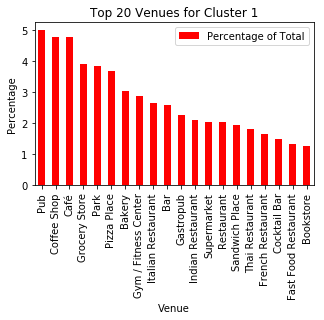

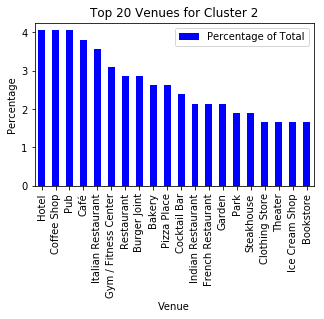

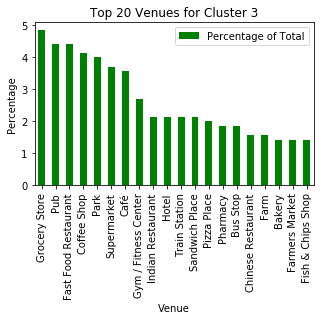

In [29]:
ClusterOneTop20 = clusterOneCount.head(20)
ClusterOneTop20.plot(kind='bar', figsize=(5,3),color = ['red'])
plt.xlabel('Venue') # add to x-label to the plot
plt.ylabel('Percentage') # add y-label to the plot
plt.title('Top 20 Venues for Cluster 1') # add title to the plot
plt.show()

ClusterTwoTop20 = clusterTwoCount.head(20)
ClusterTwoTop20.plot(kind='bar', figsize=(5,3),color = ['blue'])
plt.xlabel('Venue') # add to x-label to the plot
plt.ylabel('Percentage') # add y-label to the plot
plt.title('Top 20 Venues for Cluster 2') # add title to the plot
plt.show()

ClusterThreeTop20 = clusterThreeCount.head(20)
ClusterThreeTop20.plot(kind='bar', figsize=(5,3),color = ['green'])
plt.xlabel('Venue') # add to x-label to the plot
plt.ylabel('Percentage') # add y-label to the plot
plt.title('Top 20 Venues for Cluster 3') # add title to the plot
plt.show()

In [30]:
# Parse average property price by postal zones
propertiesPrice = pd.read_excel('https://github.com/MurtazaShafiq/Coursera_Capstone/blob/master/Property%20Values%20London.xlsx?raw=true', index_col = 0)

In [31]:
# Seperating the prices by clusters i.e. creating 4 dataframes of postcodes in each cluster with the average property prices of those postcodes
clusterOnePropertyPrice = propertiesPrice[propertiesPrice.index.isin(cluster1['Postcode'])]
clusterTwoPropertyPrice = propertiesPrice[propertiesPrice.index.isin(cluster2['Postcode'])]
clusterThreePropertyPrice = propertiesPrice[propertiesPrice.index.isin(cluster3['Postcode'])]
# clusterFourPropertyPrice = propertiesPrice[propertiesPrice.index.isin(cluster4['Postcode'])]

In [32]:
print(clusterOnePropertyPrice.describe())
print(clusterTwoPropertyPrice.describe())
print(clusterThreePropertyPrice.describe())
# print(clusterFourPropertyPrice.describe())

       Avg. paid prices
count      6.400000e+01
mean       7.332071e+05
std        3.159529e+05
min        3.488620e+05
25%        5.103745e+05
50%        6.327290e+05
75%        8.593270e+05
max        2.046685e+06
       Avg. paid prices
count      2.100000e+01
mean       1.244883e+06
std        7.435524e+05
min        3.924430e+05
25%        7.657420e+05
50%        9.100570e+05
75%        1.809516e+06
max        2.705424e+06
       Avg. paid prices
count      3.500000e+01
mean       5.454177e+05
std        1.658435e+05
min        2.792290e+05
25%        4.305180e+05
50%        5.214960e+05
75%        6.644095e+05
max        1.125879e+06


In [33]:
averagePricedf = pd.DataFrame()


averagePrice = [ pd.Series(['Cluster Two Average',clusterTwoPropertyPrice['Avg. paid prices'].mean()], index =[0,'Average Property Price']),
                pd.Series(['Cluster One Average',clusterOnePropertyPrice['Avg. paid prices'].mean()], index =[0,'Average Property Price']),
                 pd.Series(['Cluster Three Average',clusterThreePropertyPrice['Avg. paid prices'].mean()], index =[0,'Average Property Price']),]
averagePricedf=averagePricedf.append(averagePrice , ignore_index=True)

labeldf= pd.DataFrame()
labelprice = [ pd.Series(['Cluster Two Average'], index =['Average Property Price']),
                pd.Series(['Cluster One Average'], index =['Average Property Price']),
                 pd.Series(['Cluster Three Average'], index =['Average Property Price']),]
labeldf=labeldf.append(labelprice , ignore_index=True)



averagePricedf.set_index(averagePricedf[0], inplace=True)
averagePricedf.drop(axis = 1, columns = [0], inplace = True)
averagePricedf

,Average Property Price
0,
Cluster Two Average,1.244883e+06
Cluster One Average,7.332071e+05
Cluster Three Average,5.454177e+05


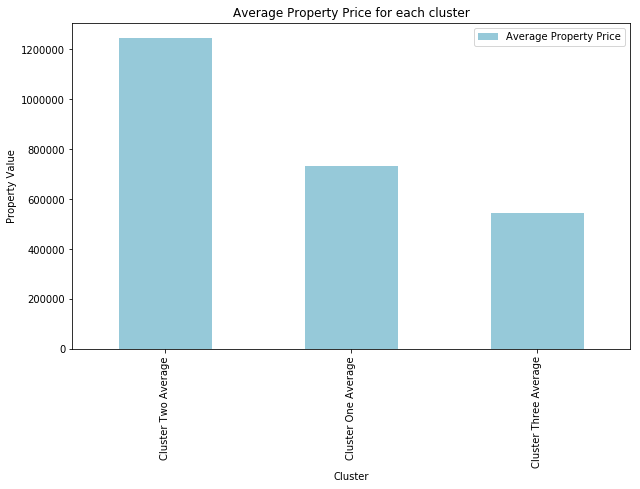

In [34]:
averagePricedf.plot(kind='bar', figsize=(10,6),color=[(0.5866, 0.787, 0.850)])
plt.xlabel('Cluster') # add to x-label to the plot
plt.ylabel('Property Value') # add y-label to the plot
plt.title('Average Property Price for each cluster') # add title to the plot
plt.show()

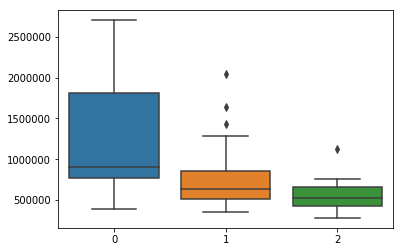

In [35]:
sns.boxplot(data = [clusterTwoPropertyPrice, clusterOnePropertyPrice, clusterThreePropertyPrice])